# Credit Card Fraud Detection with Autoencoders!

## Problem Statement

This kernel focuses on creating a tool to identify fraudulent transactions in a dataset of transations made by credit cards as outlined in the [Credit Card Fraud Detection](https://www.kaggle.com/mlg-ulb/creditcardfraud/home) dataset released on Kaggle. 

Identifying fraudulent activity is obviously an important issue for financial institutions as well as their customers. As per the dataset description:
> The datasets contains transactions made by credit cards in September 2013 by european cardholders. This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

>It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, ... V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-senstive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

We will attempt to address this using a specific type of neural network called an *autoencoder*. Before we dive into the details though, let's import all the necessary libraries to perform the task:

## Imports

In [148]:
import pdb
import sys
import os
import time
import pandas as pd
from sklearn.metrics import mean_squared_error
import pathlib
import copy
import pickle
import warnings
from datetime import datetime
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
from matplotlib import style
style.use('seaborn')

import cv2

import numpy as np
import pandas as pd

import torch
from torch import optim
from torch.autograd import Variable
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import Sampler
import torch.nn as nn

In [2]:
%matplotlib inline
pd.options.display.float_format = '{:,.2f}'.format
seed = 5
np.random.seed(seed)
torch.manual_seed(seed)

# Getting the Dataset

In [3]:
PATH = pathlib.Path('../input/'); list(PATH.iterdir())

[PosixPath('../input/creditcard.csv')]

In [5]:
df = pd.read_csv(list(PATH.iterdir())[0]); df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.00,-1.36,-0.07,2.54,1.38,-0.34,0.46,0.24,0.10,0.36,0.09,-0.55,-0.62,-0.99,-0.31,1.47,-0.47,0.21,0.03,0.40,0.25,-0.02,0.28,-0.11,0.07,0.13,-0.19,0.13,-0.02,149.62,0
1,0.00,1.19,0.27,0.17,0.45,0.06,-0.08,-0.08,0.09,-0.26,-0.17,1.61,1.07,0.49,-0.14,0.64,0.46,-0.11,-0.18,-0.15,-0.07,-0.23,-0.64,0.10,-0.34,0.17,0.13,-0.01,0.01,2.69,0
2,1.00,-1.36,-1.34,1.77,0.38,-0.50,1.80,0.79,0.25,-1.51,0.21,0.62,0.07,0.72,-0.17,2.35,-2.89,1.11,-0.12,-2.26,0.52,0.25,0.77,0.91,-0.69,-0.33,-0.14,-0.06,-0.06,378.66,0
3,1.00,-0.97,-0.19,1.79,-0.86,-0.01,1.25,0.24,0.38,-1.39,-0.05,-0.23,0.18,0.51,-0.29,-0.63,-1.06,-0.68,1.97,-1.23,-0.21,-0.11,0.01,-0.19,-1.18,0.65,-0.22,0.06,0.06,123.50,0
4,2.00,-1.16,0.88,1.55,0.40,-0.41,0.10,0.59,-0.27,0.82,0.75,-0.82,0.54,1.35,-1.12,0.18,-0.45,-0.24,-0.04,0.80,0.41,-0.01,0.80,-0.14,0.14,-0.21,0.50,0.22,0.22,69.99,0


In [6]:
df.shape

(284807, 31)

In [7]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,"284,807.00","284,807.00","284,807.00","284,807.00","284,807.00","284,807.00","284,807.00","284,807.00","284,807.00","284,807.00","284,807.00","284,807.00","284,807.00","284,807.00","284,807.00","284,807.00","284,807.00","284,807.00","284,807.00","284,807.00","284,807.00","284,807.00","284,807.00","284,807.00","284,807.00","284,807.00","284,807.00","284,807.00","284,807.00","284,807.00","284,807.00"
mean,"94,813.86",0.00,0.00,-0.00,0.00,-0.00,0.00,-0.00,-0.00,-0.00,0.00,0.00,-0.00,0.00,0.00,0.00,0.00,-0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.00,-0.00,88.35,0.00
std,"47,488.15",1.96,1.65,1.52,1.42,1.38,1.33,1.24,1.19,1.10,1.09,1.02,1.00,1.00,0.96,0.92,0.88,0.85,0.84,0.81,0.77,0.73,0.73,0.62,0.61,0.52,0.48,0.40,0.33,250.12,0.04
min,0.00,-56.41,-72.72,-48.33,-5.68,-113.74,-26.16,-43.56,-73.22,-13.43,-24.59,-4.80,-18.68,-5.79,-19.21,-4.50,-14.13,-25.16,-9.50,-7.21,-54.50,-34.83,-10.93,-44.81,-2.84,-10.30,-2.60,-22.57,-15.43,0.00,0.00
25%,"54,201.50",-0.92,-0.60,-0.89,-0.85,-0.69,-0.77,-0.55,-0.21,-0.64,-0.54,-0.76,-0.41,-0.65,-0.43,-0.58,-0.47,-0.48,-0.50,-0.46,-0.21,-0.23,-0.54,-0.16,-0.35,-0.32,-0.33,-0.07,-0.05,5.60,0.00
50%,"84,692.00",0.02,0.07,0.18,-0.02,-0.05,-0.27,0.04,0.02,-0.05,-0.09,-0.03,0.14,-0.01,0.05,0.05,0.07,-0.07,-0.00,0.00,-0.06,-0.03,0.01,-0.01,0.04,0.02,-0.05,0.00,0.01,22.00,0.00
75%,"139,320.50",1.32,0.80,1.03,0.74,0.61,0.40,0.57,0.33,0.60,0.45,0.74,0.62,0.66,0.49,0.65,0.52,0.40,0.50,0.46,0.13,0.19,0.53,0.15,0.44,0.35,0.24,0.09,0.08,77.16,0.00
max,"172,792.00",2.45,22.06,9.38,16.88,34.80,73.30,120.59,20.01,15.59,23.75,12.02,7.85,7.13,10.53,8.88,17.32,9.25,5.04,5.59,39.42,27.20,10.50,22.53,4.58,7.52,3.52,31.61,33.85,"25,691.16",1.00


In [8]:
df.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

In [9]:
class_df = df['Class'].value_counts().to_frame().reset_index()
class_df['% of total'] = class_df['Class'] / len(df) * 100
class_df.rename(columns={'index': 'Class', 'Class': 'Count'})

,Class,Count,% of total
0,0,284315,99.83
1,1,492,0.17


In [ ]:
# df["Time"] = df["Time"] / (60*60) % 24

In [10]:
hours = df.describe()['Time']['max'] / (60*60)
print(f"This dataset spans {hours:.0f} hours in total")

This dataset spans 48 hours in total


Aggregating the time feature into hours - **JUSTIFY**

In [11]:
df['Day_hrs'] = df['Time'] / (60*60) % 24

In [12]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class,Day_hrs
count,"284,807.00","284,807.00","284,807.00","284,807.00","284,807.00","284,807.00","284,807.00","284,807.00","284,807.00","284,807.00","284,807.00","284,807.00","284,807.00","284,807.00","284,807.00","284,807.00","284,807.00","284,807.00","284,807.00","284,807.00","284,807.00","284,807.00","284,807.00","284,807.00","284,807.00","284,807.00","284,807.00","284,807.00","284,807.00","284,807.00","284,807.00","284,807.00"
mean,"94,813.86",0.00,0.00,-0.00,0.00,-0.00,0.00,-0.00,-0.00,-0.00,0.00,0.00,-0.00,0.00,0.00,0.00,0.00,-0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.00,-0.00,88.35,0.00,14.54
std,"47,488.15",1.96,1.65,1.52,1.42,1.38,1.33,1.24,1.19,1.10,1.09,1.02,1.00,1.00,0.96,0.92,0.88,0.85,0.84,0.81,0.77,0.73,0.73,0.62,0.61,0.52,0.48,0.40,0.33,250.12,0.04,5.85
min,0.00,-56.41,-72.72,-48.33,-5.68,-113.74,-26.16,-43.56,-73.22,-13.43,-24.59,-4.80,-18.68,-5.79,-19.21,-4.50,-14.13,-25.16,-9.50,-7.21,-54.50,-34.83,-10.93,-44.81,-2.84,-10.30,-2.60,-22.57,-15.43,0.00,0.00,0.00
25%,"54,201.50",-0.92,-0.60,-0.89,-0.85,-0.69,-0.77,-0.55,-0.21,-0.64,-0.54,-0.76,-0.41,-0.65,-0.43,-0.58,-0.47,-0.48,-0.50,-0.46,-0.21,-0.23,-0.54,-0.16,-0.35,-0.32,-0.33,-0.07,-0.05,5.60,0.00,10.60
50%,"84,692.00",0.02,0.07,0.18,-0.02,-0.05,-0.27,0.04,0.02,-0.05,-0.09,-0.03,0.14,-0.01,0.05,0.05,0.07,-0.07,-0.00,0.00,-0.06,-0.03,0.01,-0.01,0.04,0.02,-0.05,0.00,0.01,22.00,0.00,15.01
75%,"139,320.50",1.32,0.80,1.03,0.74,0.61,0.40,0.57,0.33,0.60,0.45,0.74,0.62,0.66,0.49,0.65,0.52,0.40,0.50,0.46,0.13,0.19,0.53,0.15,0.44,0.35,0.24,0.09,0.08,77.16,0.00,19.33
max,"172,792.00",2.45,22.06,9.38,16.88,34.80,73.30,120.59,20.01,15.59,23.75,12.02,7.85,7.13,10.53,8.88,17.32,9.25,5.04,5.59,39.42,27.20,10.50,22.53,4.58,7.52,3.52,31.61,33.85,"25,691.16",1.00,24.00


## Exploratory Data Analysis

Visualise data with t-SNE and/or PCA

In [14]:
n = 1500
normal_smpl = df[df['Class'] == 0].sample(n=n)
fraud_smpl = df[df['Class'] == 1]

smpl = pd.concat((normal_smpl, fraud_smpl), axis=0).sample(frac=1).reset_index(drop=True)
inp = smpl.drop(columns=['Class', 'Time']).values
targ = smpl['Class'].values

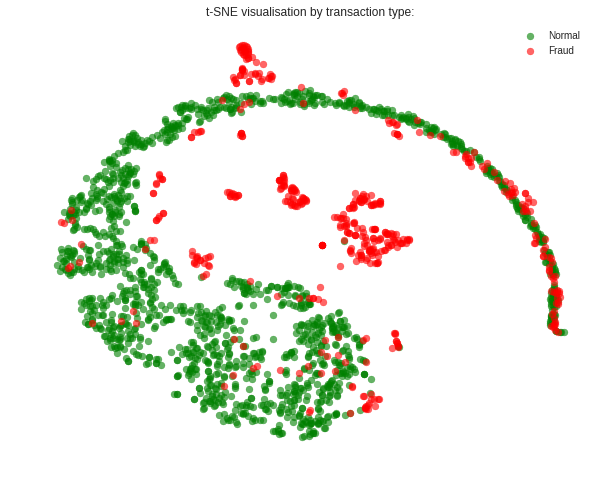

In [15]:
def tsne_plot(inp, targ):
    tsne = TSNE(n_components=2, random_state=seed)
    train = tsne.fit_transform(inp)

    plt.figure(figsize=(10,8))
    plt.title("t-SNE visualisation by transaction type:")
    plt.scatter(train[np.where(targ == 0), 0], train[np.where(targ == 0), 1], marker='o', color='g', alpha=0.6, label="Normal")
    plt.scatter(train[np.where(targ == 1), 0], train[np.where(targ == 1), 1], marker='o', color='r', alpha=0.6, label="Fraud")
    plt.legend(loc='best')
    plt.axis('off')
    plt.show()

tsne_plot(inp, targ)

Some fraudulent observation clusters seem to be easily seperable but a substantial number remains mixed with the normal transactions

Traditional EDA

In [95]:
frauds = fraud_smpl
normal = df[df['Class'] == 0]
data = {
    "Normal": normal,
    "Fraud": frauds
}

Let's check if the amount variable is different:

In [17]:
for t in data: display(t, data[t]['Amount'].describe(), "-"*20)

'Normal'

count   284,315.00
mean         88.29
std         250.11
min           0.00
25%           5.65
50%          22.00
75%          77.05
max      25,691.16
Name: Amount, dtype: float64

'--------------------'

'Fraud'

count     492.00
mean      122.21
std       256.68
min         0.00
25%         1.00
50%         9.25
75%       105.89
max     2,125.87
Name: Amount, dtype: float64

'--------------------'

Mean slightly higher for frauds but not conclusive given the std

Analysis of time:

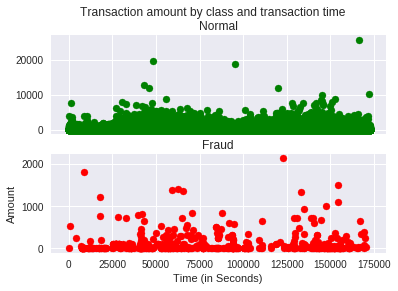

In [18]:
def plot_feature(feat):
    fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True)
    fig.suptitle('Transaction amount by class and transaction time')
    for i in (0, 1):
        t = ['Normal', 'Fraud'][i]
        ax[i].scatter(data[t][feat], data[t]['Amount'], color=['g', 'r'][i])
        ax[i].set_title(t)
    plt.xlabel('Time (in Seconds)')
    plt.ylabel('Amount')
    plt.show()

plot_feature('Time')

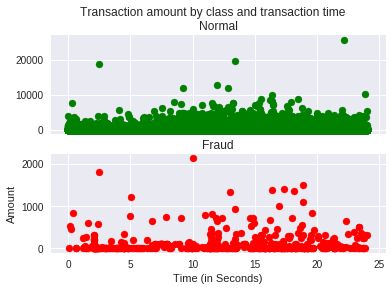

In [19]:
plot_feature('Day_hrs')

# Model - Autoencoder

PREPARING THE DATA

We will be training the autoencoder only on the normal transactions. This way, the autoencoder will fit to what a normal transaction should look like and when we pass in a fraudulent transaction, it should produce a higher error

In [184]:
class DFNormaliser:
    
    def __init__(self):
        self.mean = 0
        self.std = 0
        
    def fit(self, df):
        self.mean = df.mean()
        self.std = df.std()        
    
    def transform(self, df):
        df = (df - self.mean) / self.std
        return df
    
    def fit_transform(self, df):
        self.fit(df)
        return self.transform(df)
    
    def inv_transform(self, df):
        df = df * self.std + self.mean
        return df

In [221]:
class DFScaler:
    
    def __init__(self):
        self.min = 0
        self.max = 0
        
    def fit(self, df):
        self.min = df.min()
        self.max = df.max()        
    
    def transform(self, df):
        df = (df - self.min) / (self.max - self.min)
        return df
    
    def fit_transform(self, df):
        self.fit(df)
        return self.transform(df)
    
    def inv_transform(self, df):
        df = df * (self.max - self.min) + self.min
        return df

**DROP TIME??**

In [296]:
split = 0.3

# normaliser = DFNormaliser()
scaler = DFScaler()

norm = normal.drop(columns=['Time']).sample(frac=0.1)
# norm = normaliser.fit_transform(norm)
norm = scaler.fit_transform(norm)
train = norm.sample(frac=(1-split))
val = norm[~norm.index.isin(train.index)]
normal.shape, norm.shape, train.shape, val.shape

((284315, 32), (28432, 31), (19902, 31), (8530, 31))

DATASET DEFINITION:

In [250]:
class FraudDataset(Dataset):
    
    def __init__(self, dset):
        self.tset = dset.drop(columns=['Class'])
        self.y_tset = dset['Class']
        
    def __len__(self):
        return len(self.tset)
    
    def __getitem__(self, idx):
        inp = torch.cuda.FloatTensor(self.tset.iloc[idx, :])
        lab = torch.cuda.FloatTensor([self.y_tset.iloc[idx]])
        return [inp, lab]

**DATASETS**

In [297]:
bs = 1024
dset = FraudDataset(train)
vset = FraudDataset(val)
train_loader = DataLoader(dset, batch_size=bs, shuffle=True)
val_loader = DataLoader(vset, batch_size=bs)
x, y = next(iter(train_loader))

MODEL DEFINITION

In [81]:
def activation(act='Tanh'):
    di = {
        'tanh': nn.Tanh(),
        'relu': nn.ReLU(),
        'lrelu': nn.LeakyReLU()
    }
    return di[act]

In [198]:
class AE_layer(nn.Module):
    
    def __init__(self, s_inp, s_out, p, act):
        super().__init__()
        self.s_inp, self.s_out = s_inp, s_out
        self.p, self.act = p, act
        self.layer = nn.Sequential(
#             nn.BatchNorm1d(self.s_inp),
            nn.Linear(self.s_inp, self.s_out),
            nn.Dropout(self.p),
#             nn.BatchNorm1d(self.s_out),
            activation(self.act)
        )
    
    def forward(self, x):
        return self.layer(x)

In [216]:
class Autoencoder(nn.Module):
    
    def __init__(self, train, p=0.3):
        super().__init__()
        
        self.inp_sz = train.shape[1] - 1
        self.p = p
        
        self.encoder = nn.Sequential(
            AE_layer(self.inp_sz, 100, p=self.p, act='tanh'),
            AE_layer(100, 50, p=self.p, act='tanh'),
            nn.Linear(50, 50),
            nn.LeakyReLU()
        )
#         self.latent = nn.Sequential(
#             nn.Linear(50, 50),
#             nn.LeakyReLU()
#         )
        self.decoder = nn.Sequential(
            AE_layer(50, 100, p=self.p, act='tanh'),
            AE_layer(100, self.inp_sz, p=self.p, act='lrelu')
        )
        
        print(self)
        
    def forward(self, x):
        x = self.encoder(x)
#         x = self.latent(x)
        x = self.decoder(x)
        return x

TRAINING LOOP

In [121]:
def evaluate(model):
    mse = []
    for i, data in enumerate(val_loader):
        x = data[0]
        out = model(x)
        loss = mean_squared_error(x.cpu().data.numpy(), out.cpu().data.numpy())
        mse.append(loss)
    return np.mean(mse)

In [209]:
def train_ae(model, train_loader, n_epochs, lr, 
              prints_per_epoch=10, cycles=1):
    print("HYPERPARAMETERS\n", "_"*30, f"\nBatch size (w. augs): {bs}\nLearning rate: {lr}\nNumber of Epochs: {n_epochs}\n", "_"*30)  
    n_batches = len(train_loader)
    training_start_time = time.time()
    print_every = n_batches // prints_per_epoch
    print_loss = []
    
    loss = nn.MSELoss().cuda()
#     opt = optim.Adam(model.parameters(), lr=lr)
    opt = optim.Adadelta(model.parameters())
    

    # Main loop:
    for epoch in range(n_epochs):
        running_loss = 0.0
        start_time = time.time()
        total_train_loss = 0
        
        # reset the scheduler:
        if epoch % cycles == 0: 
            scheduler = optim.lr_scheduler.CosineAnnealingLR(opt, len(train_loader) * cycles, eta_min=lr/1e4)
        
        for i, data in enumerate(train_loader, 0):
            inp = data[0]
            opt.zero_grad()
            out = model(inp)
            loss_size = loss(out, inp)
            loss_size.backward()
            opt.step()
            scheduler.step()
            
            # Stats:
            running_loss += loss_size.item()
            
            # Printing:
            if (i + 1) % (print_every + 1) == 0:
                print(f"Epoch {epoch + 1} [{100 * (i + 1) / n_batches:.0f}% done] - Training Loss: {running_loss / print_every:.4f}, Elapsed Time: {time.time() - start_time:.0f}s")
                print_loss.append(running_loss / print_every)
                running_loss = 0.0
                start_time = time.time()
        print("-"*40, f"\nEnd of Epoch {epoch + 1} Validation MSE: {evaluate(model):.4f}\n","_"*40)
    total_time = int(time.time() - training_start_time)
    print(f"TRAINING COMPLETE - Total Elapsed Time: {total_time // 60}m{total_time % 60}s")
    if prints_per_epoch:
        plt.figure()
        plt.plot(print_loss)
        plt.ylabel("Loss")
        plt.xticks([], [])
        plt.show()

In [298]:
def find_lr(model, train_loader, crop=1, p=10):
    loss=nn.MSELoss().cuda()
    model = copy.deepcopy(model)
    p += crop
    lrs = [round(eval("1e-" + str(p)) * 10**i, p - i) for i in range(p + 1)] + [2]
    losses = []
    for lr in lrs:
#         opt = optim.Adam(params=model.parameters(), lr=lr)
        opt = optim.Adadelta(model.parameters())
        inp = next(iter(train_loader))[0]
        opt.zero_grad()
        out = model(inp)
        loss_size = loss(out, inp)
        loss_size.backward()
        opt.step()
        losses.append(float(loss_size.cpu().data.numpy()))
    los = losses[1 + crop:-crop]
    lrs = lrs[crop:-(crop + 1)]
    plt.plot(los)
    plt.xticks(list(range(len(los))), lrs, rotation='vertical')
    plt.xlabel("Learning rate")
    plt.ylabel("Loss")
    plt.show()

TRAINING

In [299]:
model = Autoencoder(train).cuda()

Autoencoder(
  (encoder): Sequential(
    (0): AE_layer(
      (layer): Sequential(
        (0): Linear(in_features=30, out_features=100, bias=True)
        (1): Dropout(p=0.3)
        (2): Tanh()
      )
    )
    (1): AE_layer(
      (layer): Sequential(
        (0): Linear(in_features=100, out_features=50, bias=True)
        (1): Dropout(p=0.3)
        (2): Tanh()
      )
    )
    (2): Linear(in_features=50, out_features=50, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
  )
  (decoder): Sequential(
    (0): AE_layer(
      (layer): Sequential(
        (0): Linear(in_features=50, out_features=100, bias=True)
        (1): Dropout(p=0.3)
        (2): Tanh()
      )
    )
    (1): AE_layer(
      (layer): Sequential(
        (0): Linear(in_features=100, out_features=30, bias=True)
        (1): Dropout(p=0.3)
        (2): LeakyReLU(negative_slope=0.01)
      )
    )
  )
)


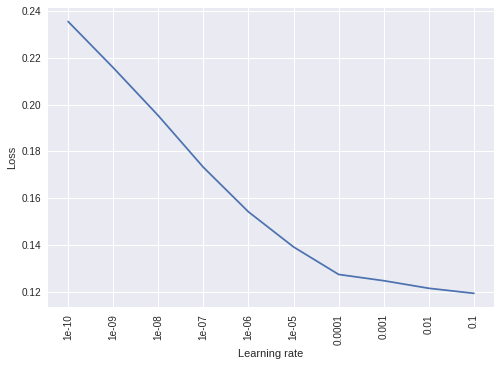

In [300]:
find_lr(model, train_loader)

HYPERPARAMETERS
 ______________________________ 
Batch size (w. augs): 1024
Learning rate: 0.001
Number of Epochs: 10
 ______________________________
Epoch 1 [15% done] - Training Loss: 0.3737, Elapsed Time: 1s
Epoch 1 [30% done] - Training Loss: 0.2880, Elapsed Time: 1s
Epoch 1 [45% done] - Training Loss: 0.2079, Elapsed Time: 1s
Epoch 1 [60% done] - Training Loss: 0.1838, Elapsed Time: 1s
Epoch 1 [75% done] - Training Loss: 0.1769, Elapsed Time: 1s
Epoch 1 [90% done] - Training Loss: 0.1749, Elapsed Time: 1s
---------------------------------------- 
End of Epoch 1 Validation MSE: 0.1159
 ________________________________________
Epoch 2 [15% done] - Training Loss: 0.1738, Elapsed Time: 1s
Epoch 2 [30% done] - Training Loss: 0.1708, Elapsed Time: 1s
Epoch 2 [45% done] - Training Loss: 0.1696, Elapsed Time: 1s
Epoch 2 [60% done] - Training Loss: 0.1692, Elapsed Time: 1s
Epoch 2 [75% done] - Training Loss: 0.1674, Elapsed Time: 1s
Epoch 2 [90% done] - Training Loss: 0.1649, Elapsed Time:

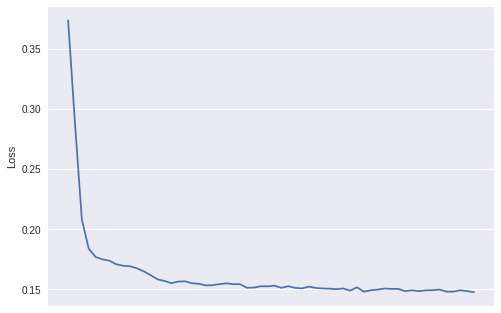

In [301]:
train_ae(model, train_loader=train_loader, n_epochs=10, lr=1e-3)

Classifier based on Autoencoder Error

Classifier based on Autoencoder latent vector

In [302]:
encoder = model.encoder

In [305]:
norm_lat = normal.drop(columns=['Time']).sample(n=n)
norm_lat = scaler.transform(norm_lat)
norm_lat = torch.cuda.FloatTensor(norm_lat.drop(columns=['Class']).values)

fraud_lat = scaler.transform(frauds.drop(columns=['Time']))
fraud_lat = torch.cuda.FloatTensor(fraud_lat.drop(columns=['Class']).values)
norm_lat.shape, fraud_lat.shape

(torch.Size([1500, 30]), torch.Size([492, 30]))

In [306]:
nor = encoder(norm_lat).cpu().data.numpy()
fra = encoder(fraud_lat).cpu().data.numpy()
inp = np.concatenate((nor, fra), axis=0)

zeros = np.zeros(len(nor))
ones = np.ones(len(fra))
targ = np.concatenate((zeros, ones), axis=0)

In [ ]:
tsne_plot(inp, targ)

Final stats